In [20]:
import fnmatch
import os
import random
import re
import threading
import pandas as pd
import time
import copy
from tqdm import tqdm

import librosa
import numpy as np


import matplotlib.pyplot as plt

%matplotlib inline

FILE_PATTERN = r'*.wav'

In [25]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.model_selection import validation_curve, learning_curve
from sklearn.metrics import log_loss, accuracy_score, precision_recall_curve, auc
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Load data

In [26]:
def randomize_files(files):
    '''Shuffle loaded files'''
    for file in files:
        file_index = random.randint(0, (len(files) - 1))
        yield files[file_index]


def find_files(directory, pattern='*.wav'):
    '''Recursively finds all files matching the pattern.'''
    files = []
    fnames = []
    for root, dirnames, filenames in os.walk(directory):
        for filename in fnmatch.filter(filenames, pattern):
            files.append(os.path.join(root, filename))
            fnames.append(filename)
    return files, fnames

def get_category(fname):
    '''Parse type from fnamepar'''
    return fname.split('/')[-1].split('_')[0]

def load_generic_audio(files, sample_rate, amount):
    '''Generator that yields audio waveforms from the directory.'''
    for it, filename in enumerate(files):
        if it == amount:
            break
        category_id = get_category(filename)
        audio, _ = librosa.load(filename, sr=sample_rate, mono=True)
        audio = audio.reshape(-1, 1)
        yield audio, filename, category_id

# Второе дополнительное задание !!!
def trim_silence(audio, threshold, frame_length=512):
    '''Removes silence at the beginning and end of a sample.'''
    if audio.size < frame_length:
        frame_length = audio.size
    energy = librosa.feature.rmse(audio, frame_length=frame_length)
    frames = np.nonzero(energy > threshold)
    indices = librosa.core.frames_to_samples(frames)[1]

    # Indices can be an empty array, if the whole audio was background.
    return audio[indices[0]:indices[-1]] if indices.size else audio[0:0]



class AudioReader(object):
    '''Noise audio reader that preprocesses audio files
    and add tham in lists'''

    def __init__(self,
                 audio_dir,
                 sample_rate,
                 silence_threshold=None,
                 sample_size=None,
                 load_size=None):
        self.audio_dir = audio_dir
        self.sample_rate = sample_rate
        self.sample_size = sample_size
        self.silence_threshold = silence_threshold
        self.load_size = load_size
        self.counter = 0
        self.time = time.time()

        # TODO Find a better way to check this and deal with empty audio.
        
        self.files, self.fnames = find_files(audio_dir)
        if not self.files:
            raise ValueError("No audio files found in '{}'.".format(audio_dir))
        self.pred_category = np.full(len(self.files), True)
        if load_size is not None:
            self.data = [0]*load_size
            self.id = [0]*load_size
        else:    
            self.data = [0]*len(self.files)
            self.id = [0]*len(self.files)


    def read(self):
        #Read dataset
        
        iterator = load_generic_audio(self.files, self.sample_rate, self.load_size)
        for audio, filename, category_id in iterator:
            if self.silence_threshold is not None:
                # Remove silence
                audio = trim_silence(audio[:, 0], self.silence_threshold)
                audio = audio.reshape(-1)
                if audio.size == 0:
                    self.pred_category[self.counter]=False


            self.data[self.counter] = audio
            self.id[self.counter] = category_id
            self.counter += 1
            if self.counter % 400 == 0:
                print (time.time() - self.time,self.counter)
        return self

In [36]:
audio_dir = './data_v_7_stc/audio' 
test_dir='./data_v_7_stc/test'
sr = 16000
silence_threshold = 8e-4
drop = False #use zero-size sample at training and predictions 

In [37]:
_, fnames = find_files(audio_dir)
_, fnames_test = find_files(test_dir)

In [27]:
audio_reader = AudioReader(audio_dir,sr,silence_threshold=silence_threshold,load_size=None)
audio_reader.read()

29.956872940063477 400
60.12695932388306 800
88.32930779457092 1200
114.39257192611694 1600
146.94878315925598 2000
178.91525554656982 2400
208.0892550945282 2800
237.8408613204956 3200
264.34969830513 3600
292.2403333187103 4000
319.7210924625397 4400
345.89164543151855 4800
372.84616255760193 5200
402.2528955936432 5600
432.67646503448486 6000
461.3338055610657 6400
489.98981523513794 6800
521.3770434856415 7200
550.9944922924042 7600
579.8056807518005 8000
609.4759435653687 8400
637.8871190547943 8800
669.1229331493378 9200
699.226235628128 9600
726.9619619846344 10000
761.3581113815308 10400
790.1097180843353 10800
816.3173453807831 11200


In [8]:
meta = pd.read_csv('./data_v_7_stc/meta/meta.txt',sep = '\t')
meta.drop(columns=['*','time_start'],inplace=True)
to = {'background':0,'bags':1,'door':2,'keyboard':3,'knocking_door':4,'ring':5,'speech':6,'tool':7}
fr = {0:'background',1:'bags',2:'door',3:'keyboard',4:'knocking_door',5:'ring',6:'speech',7:'tool'}
meta['type'] = meta['type'].map(to)

In [ ]:
mask = np.invert(audio_reader.pred_category)

# Choice of silence_threshold

(1, 91) (46086,) 16000


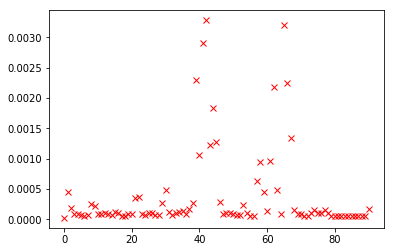

In [153]:
path = './data_v_7_stc/audio/background_0019_time_stretch_13.wav' 
sr = 16000
audio, _ = librosa.load(path, sr=sr, mono=True)
energy = librosa.feature.rmse(audio, frame_length=512)
print (energy.shape, audio.shape, 16000)
plt.plot(energy.reshape(-1), 'rx');

In [116]:
files = find_files('./data_v_7_stc/audio')
files[0].split('/')[-1].split('_')[0]
def get_type(a):
    return a.split('/')[-1].split('_')[0]

In [223]:
s = 0
files = meta[meta['type'] == 0]['fname']
rm = np.zeros((len(files),4))
for i, file in  enumerate(files):
    path = audio_dir + '/' + file
    audio, _ = librosa.load(path, sr=sr, mono=True)
    energy = librosa.feature.rmse(audio, frame_length=512) 
    rm[i] = (energy.max(),energy.mean(),energy.std(),energy.min())
    if energy.max() > s:
        s = energy.max()
plt.hist(rm1[:,1], bins=12)

background_0001.wav 0.00131564
background_0001_time_stretch_5.wav 0.00131575
background_0004.wav 0.00503398
background_0004_time_stretch_1.wav 0.00526163
background_0007.wav 0.00769703
background_0014.wav 0.0453071
background_0014_time_stretch_0.wav 0.0506213
background_0042.wav 0.182996
background_0042_time_stretch_0.wav 0.189449
background_0042_time_stretch_3.wav 0.191987
0.191987


In [190]:
s = 0
files2 = meta[meta['type'] == 1]['fname']
rm2 = np.zeros((len(files2),4))
for i, file in  enumerate(files2):
    path = audio_dir + '/' + file
    audio, _ = librosa.load(path, sr=sr, mono=True)
    energy = librosa.feature.rmse(audio, frame_length=512) 
    rm2[i] = (energy.max(),energy.mean(),energy.std(),energy.min())
    if energy.max() > s:
        s = energy.max()
plt.hist(rm2[:,1], bins=12)

bags_0001.wav 0.0541228
bags_0002.wav 0.24719
bags_0033.wav 0.301132
bags_0033_time_stretch_3.wav 0.310277
bg_0009.wav 0.363868
bg_0010.wav 0.522466
0.522466


(array([   0.,    0.,    0.,    0.,  516.,    0.,    0.,    0.]),
 array([-0.5  , -0.375, -0.25 , -0.125,  0.   ,  0.125,  0.25 ,  0.375,  0.5  ]),
 <a list of 8 Patch objects>)

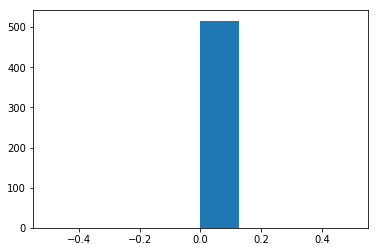

In [9]:
# hist of threshold sample by catigory

meta2 = meta.set_index('fname')
files = [0]*len(audio_reader.files)
for i,f in enumerate(audio_reader.files):
    files[i]=f.split('/')[-1]
y_train = np.array(meta2.loc[files]['type'])
zerro_level = y_train[mask]
plt.hist(zerro_level,bins = 8)


# Feature Extraction

## 1.All feature

In [7]:
def extract_feature(X,sample_rate):
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
#     tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X), sr=sample_rate).T,axis=0)
    return mfccs,chroma,mel,contrast

In [9]:
np.save('y_train',y_train)
np.save('all_features_train',X_train)

In [8]:
n=len(audio_reader.data)
X_train = np.zeros((n,187))
start = time.time()
for i,arr in enumerate(audio_reader.data):
    if arr.size == 0:
        continue
    mfccs, chroma, mel, contrast= extract_feature(arr,sr)
    X_train[i] = np.hstack([mfccs,chroma,mel,contrast])
    if i%500 == 0:
        print (i, time.time()-start)
meta2 = meta.set_index('fname')
files = [0]*len(audio_reader.files)
for i,f in enumerate(audio_reader.files):
    files[i]=f.split('/')[-1]
y_train = np.array(meta2.loc[files]['type'])

0 0.7706301212310791
500 25.03000497817993


/home/ilya/anaconda3/lib/python3.6/site-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


1000 46.00137400627136
1500 67.7959680557251
2000 91.39860916137695
2500 116.05993962287903
3000 137.24662017822266
3500 156.7050952911377
4000 176.81011581420898
4500 198.76968717575073
5500 240.84956550598145
6000 263.1098737716675
6500 283.9925694465637
7000 304.77506041526794
7500 324.5779366493225
8000 346.3171019554138
8500 366.4724006652832
9000 385.82745242118835
9500 407.44711232185364
10000 433.6474587917328
10500 452.80565452575684
11000 472.25967049598694


In [10]:
test_dir='./data_v_7_stc/test'
test_reader = AudioReader(test_dir,sr,silence_threshold=silence_threshold)
test_reader.read()
n=len(test_reader.data)
X_full = np.zeros((n,187))
start = time.time()
for i,arr in enumerate(test_reader.data):
    if arr.size == 0:
        continue
    mfccs, chroma, mel, contrast= extract_feature(arr,sr)
    X_full[i] = np.hstack([mfccs,chroma,mel,contrast])
    if i%500 == 0:
        print (i, time.time()-start)
to = {'background':0,'bags':1,'door':2,'keyboard':3,'knocking':4,'ring':5,'speech':6,'tool':7}
T = np.array(test_reader.id)
X_test, y_test =X_full[T != 'unknown'],  np.array([to[x] for x in T[T != 'unknown']])
X_unknown = X_full[T == 'unknown']
mask_test = np.invert(test_reader.pred_category[T != 'unknown'])

6.119609355926514 400
0 0.05855250358581543
500 22.81306219100952


In [11]:
np.save('T',T)
np.save('X_full_test_all_features',X_full)

In [12]:
if drop:
    _X_train, _y_train = copy.deepcopy(X_train), copy.deepcopy(y_train)
    X_train, y_train = X_train[audio_reader.pred_category], y_train[audio_reader.pred_category]

### Load features

In [53]:
#Load pre_saved feature
X_train = np.load('all_features_train.npy')
y_train = np.load('y_train.npy')
X_full = np.load('X_full_test_all_features.npy')
T = np.load('T.npy')

wavenet_dir = './wavenet_features'
wav_feat = np.zeros((len(fname),16))
for i,file in enumerate(tqdm(fnames)):
    path = wavenet_dir + '/' + file + '.npy'
    if os.path.isfile(path):
        wav_feat[i] = np.mean(np.load(path))

wavenet_dir = './test_feats'
wav_feat_test = np.zeros((len(fnames_test),16))
for i,file in enumerate(tqdm(fnames_test)):
    path = wavenet_dir + '/' + file + '.npy'
    if os.path.isfile(path):
        wav_feat_test[i] = np.mean(np.load(path))
                                           
X_train = np.hstack((X_train,wav_feat))
X_full = np.hstack((X_full,wav_feat_test)) 

to = {'background':0,'bags':1,'door':2,'keyboard':3,'knocking':4,'ring':5,'speech':6,'tool':7}
X_test, y_test =X_full[T != 'unknown'],  np.array([to[x] for x in T[T != 'unknown']])
X_unknown = X_full[T == 'unknown']

100%|██████████| 610/610 [00:00<00:00, 2350.50it/s]


## 2. mfcc only

In [9]:
n=len(audio_reader.data)
X_train = np.zeros((n,6))
start = time.time()
for i,arr in enumerate(audio_reader.data):
    if arr.size == 0:
        continue
    X_train[i]=np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(arr), sr=sr).T,axis=0)
    if i%500 == 0:
        print (i, time.time()-start)
meta2 = meta.set_index('fname')
files = [0]*len(audio_reader.files)
for i,f in enumerate(audio_reader.files):
    files[i]=f.split('/')[-1]
y_train = np.array(meta2.loc[files]['type'])

0 1.0687875747680664


/home/ilya/anaconda3/lib/python3.6/site-packages/librosa/core/pitch.py:145: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn('Trying to estimate tuning from empty frequency set.')


500 157.42805886268616


/home/ilya/anaconda3/lib/python3.6/site-packages/librosa/util/utils.py:1467: RuntimeWarning: invalid value encountered in less
  if np.any(X < 0) or np.any(X_ref < 0):
/home/ilya/anaconda3/lib/python3.6/site-packages/librosa/util/utils.py:1480: RuntimeWarning: invalid value encountered in less
  bad_idx = (Z < np.finfo(dtype).tiny)


ParameterError: Audio buffer is not finite everywhere

In [56]:
test_dir='./data_v_7_stc/test'
test_reader = AudioReader(test_dir,sr,silence_threshold=silence_threshold)
test_reader.read()
n=len(test_reader.data)
X_full = np.zeros((n,40))
start = time.time()
for i,arr in enumerate(test_reader.data):
    if arr.size == 0:
        continue
    X_full[i]=np.mean(librosa.feature.mfcc(arr,sr,n_mfcc=40).T,axis=0)
    if i%300 == 0:
        print (i, time.time()-start)
to = {'background':0,'bags':1,'door':2,'keyboard':3,'knocking':4,'ring':5,'speech':6,'tool':7}
T = np.array(test_reader.id)
X_test, y_test =X_full[T != 'unknown'],  np.array([to[x] for x in T[T != 'unknown']])
X_unknown = X_full[T == 'unknown']

0.24065589904785156 100
0.4848320484161377 200
0.7339329719543457 300
0.9544987678527832 400
1.198190450668335 500
1.4346206188201904 600
0 0.011100292205810547
300 4.476659774780273
600 8.003519296646118


# Classification part

In [51]:
def score_model(clf, title):
    kfold = KFold(n_splits=3)
    cv_res = np.mean(cross_val_score(clf, X_train, y_train, cv=kfold, scoring='neg_log_loss'))
    print(title, "Cross_Entropy_Loss: {0:.3f}".format(cv_res))

In [135]:
models = [
    (RandomForestClassifier(max_depth = 10,n_n_estimators = 100,random_state=17), "Случайный лес"),
    (XGBClassifier(max_depth = 3,n_n_estimators = 1000,random_state=17), "Градиентный бустинг(xgb)")
]

for pair in models:
    score_model(*pair)

SVM CE: -0.507
Случайный лес CE: -0.266
Градиентный бустинг(sklearn) CE: -1.840
Градиентный бустинг(xgb) CE: -0.240


In [55]:
xgb = XGBClassifier(random_state=17)
kfold = KFold(n_splits=5)
parameters = {'n_estimators':[100,500,1000,1500],
              'max_depth': [2,3,4],
             }
grid = GridSearchCV(xgb, parameters, n_jobs=-1, 
                    cv=kfold, scoring='neg_log_loss', refit=True)
grid.fit(X_train, y_train);

## Обучение классификатора

In [64]:
xgb =  XGBClassifier(n_estimators=3000, max_depth=3 ,n_jobs=-1, random_state=17)
xgb.fit(X_train, y_train)
pred = xgb.predict_proba(X_test)
idx, score = pred.argmax(axis=1), pred.max(axis=1)
if drop:
    idx[mask_test] = 0
    score[mask_test] = 1
accuracy_score(y_test,idx), log_loss(y_test,pred)

(0.94503171247357298, 0.21528591295804647)

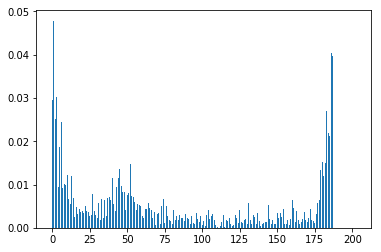

In [63]:
plt.bar(range(len(xgb.feature_importances_)), xgb.feature_importances_)
plt.show()

In [62]:
pred = xgb.predict_proba(X_train)
idx, score = pred.argmax(axis=1), pred.max(axis=1)
accuracy_score(y_train,idx), log_loss(y_train,pred)

(1.0, 0.0042516821488229077)

In [20]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)

ohe = onehot_encoder.fit_transform(y_test.reshape(-1,1))
ohe.shape, pred.shape

((473, 8), (473, 8))

In [67]:
def write_pred(est, arr,files,drop): 
    pred = est.predict_proba(arr)
    idx, score = pred.argmax(axis=1), pred.max(axis=1)
    if drop:
        idx[np.invert(test_reader.pred_category)] = 0
        score[np.invert(test_reader.pred_category)] = 1
    lables = np.array([fr[x] for x in idx])
    res = np.column_stack((files,score,lables))
    print (res)
    np.savetxt('to_ret_all-3.txt',res,delimiter='\t',fmt="%s")
write_pred(xgb,X_full,fnames_test,drop)

[['door_t_0019.wav' '0.9942910671234131' 'door']
 ['unknown_0095.wav' '0.6291758418083191' 'knocking_door']
 ['knocking_door_t_0009.wav' '0.9999544620513916' 'knocking_door']
 ..., 
 ['door_t_0014.wav' '0.982999861240387' 'door']
 ['unknown_0107.wav' '0.8238789439201355' 'tool']
 ['speech_0051.wav' '0.8677757978439331' 'speech']]


In [65]:
from sklearn.decomposition import PCA

In [68]:
pca = PCA()
pca.fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)